# STOCK PRICE PREDICTION WITH LSTM AND GRU
Predicting stock prices of PT Adaro Energy Indonesia

## IMPORT DATA AND LIBRARIES

In [ ]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import math
from sklearn.metrics import mean_squared_error

In [ ]:
# Some functions to help out with this code
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real ADRO Stock Price')
    plt.plot(predicted, color='blue',label='Predicted ADRO Stock Price')
    plt.title('ADRO Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('ADRO Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

Import the ADRO.CSV data, set the 'timestamp' column as the index, and convert its format to DateTime

In [ ]:
# First, we get the data
dataset = pd.read_csv('ADRO.csv', index_col='timestamp', parse_dates=['timestamp'])
dataset

,open,low,high,close,volume
timestamp,,,,,
2008-07-16,1500,1500,1760,1730,789786000
2008-07-17,1700,1700,1760,1700,383602500
2008-07-18,1640,1640,1700,1640,95396000
2008-07-21,1680,1640,1690,1680,49749000
2008-07-22,1670,1660,1690,1670,29585500
...,...,...,...,...,...
2023-01-02,3610,3590,3650,3590,69696600
2023-01-03,3590,3500,3590,3520,95601300
2023-01-04,3540,3300,3560,3300,163804600


## EDA (Exploratory Data Analysis)

In [ ]:
dataset.describe()

,open,low,high,close,volume
count,3778.000000,3778.000000,3778.000000,3778.000000,3.778000e+03
mean,1547.273425,1519.896771,1573.661726,1545.987030,6.072940e+07
std,679.711946,670.024085,689.409619,680.601818,5.698739e+07
min,440.000000,437.000000,452.000000,437.000000,0.000000e+00
25%,1101.250000,1085.000000,1130.000000,1100.000000,2.619512e+07
50%,1405.000000,1380.000000,1430.000000,1405.000000,4.652895e+07
75%,1875.000000,1850.000000,1898.750000,1870.000000,7.885675e+07
max,4140.000000,4080.000000,4250.000000,4140.000000,7.897860e+08


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3778 entries, 2008-07-16 to 2023-01-06
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   open    3778 non-null   int64
 1   low     3778 non-null   int64
 2   high    3778 non-null   int64
 3   close   3778 non-null   int64
 4   volume  3778 non-null   int64
dtypes: int64(5)
memory usage: 177.1 KB


In [ ]:
dataset.isnull().sum()

,0
open,0
low,0
high,0
close,0
volume,0


In [ ]:
dataset.duplicated().sum()

np.int64(108)

The dataset consists of 3.778 records spanning the period from July 16, 2008, to January 6, 2023. Based on the inspection results, there are no missing values in this dataset, so no handling of missing data is necessary.

There are 108 duplicate rows; however, in the context of stock data, the occurrence of identical values at different times is common, as stock prices can remain stagnant or experience similar movements during certain periods. Therefore, these duplicate rows are not removed, as they still represent valid market conditions.

## FEATURE ENGINEERING

In [ ]:
# Split the data into training and testing sets
training_set = dataset[:'2021'].iloc[:,1:2].values
test_set = dataset['2022':].iloc[:,1:2].values

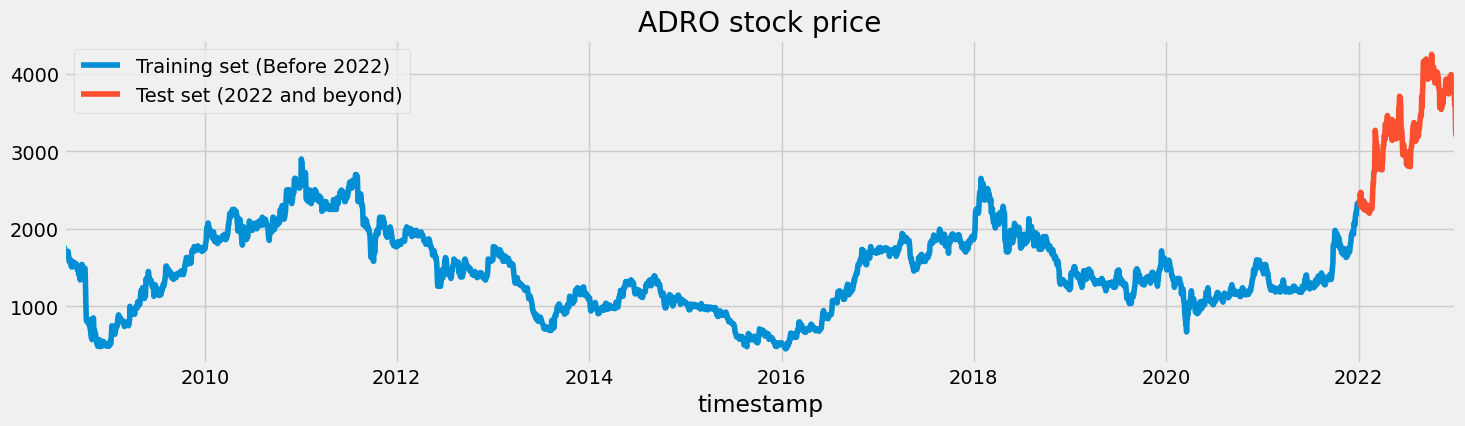

In [ ]:
# We have chosen 'high' attribute for prices. Let's see what it looks like
dataset["high"][:'2021'].plot(figsize=(16,4),legend=True)
dataset["high"]['2022':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2022)','Test set (2022 and beyond)'])
plt.title('ADRO stock price')
plt.show()

In [ ]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
training_set_scaled.shape

(3513, 1)

In [ ]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements
X_train = []
y_train = []
for i in range(60,3513):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

## MODELLING AND EVALUATION

### LSTM (LONG SHORT-TERM MEMORY)

In [ ]:
# The LSTM architecture
model_lstm = Sequential()
# First LSTM layer with Dropout regularisation
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model_lstm.add(Dropout(0.2))
# Second LSTM layer
model_lstm.add(LSTM(units=50, return_sequences=True))
model_lstm.add(Dropout(0.2))
# Third LSTM layer
model_lstm.add(LSTM(units=50, return_sequences=True))
model_lstm.add(Dropout(0.2))
# Fourth LSTM layer
model_lstm.add(LSTM(units=50))
model_lstm.add(Dropout(0.2))
# The output layer
model_lstm.add(Dense(units=1))

# Compiling the RNN
model_lstm.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
model_lstm.fit(X_train,y_train,epochs=50,batch_size=32)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - loss: 0.0266
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step - loss: 0.0081
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - loss: 0.0064
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - loss: 0.0053
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - loss: 0.0049
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - loss: 0.0041
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - loss: 0.0038
Epoch 8/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - loss: 0.0033
Epoch 9/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - loss: 0.0031
Epoch 10/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - loss: 0.0031
Epoch 11/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - loss: 0.0028
Epoch 12/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - loss: 0.0026
Epoch 13/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - loss: 0.0024
Epoch 14/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - loss: 0.0023
Epoch 15/50
108

In [ ]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole
# 'high' attribute data for processing
dataset_total = pd.concat((dataset["high"][:'2021'],dataset["high"]['2022':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [ ]:
inputs.shape

(325, 1)

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,325):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = model_lstm.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step


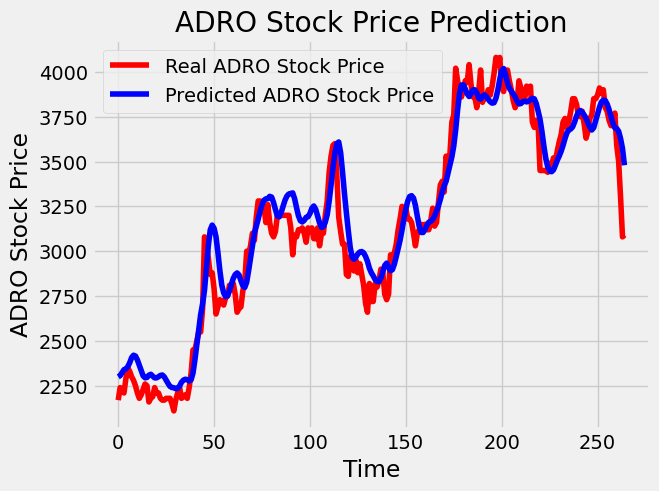

In [ ]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [ ]:
# Evaluating LSTM with RMSE and MAPE
rmse = np.sqrt(np.mean((test_set - predicted_stock_price) ** 2))
print(f"RMSE: {rmse:.4f}")

from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(test_set, predicted_stock_price)
print(f"MAPE: {mape*100:.2f}%")

from sklearn.metrics import r2_score
r2 = r2_score(test_set, predicted_stock_price)
print(f"R²: {r2:.4f}")

RMSE: 135.3097
MAPE: 3.42%
R²: 0.9412


Qualitatively, the graph shows that the predicted data has a pattern that closely resembles the actual data.

Quantitatively, the following values were obtained for model evaluation:
- RMSE: 135.3097
- MAPE: 3.42%
- R2: 0.9412

### LSTM with GRU (GATED RECURRENT UNIT)

In [ ]:
# The GRU architecture
LSTM_GRU = Sequential()
# First GRU layer with Dropout regularisation
LSTM_GRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
LSTM_GRU.add(Dropout(0.2))
# Second GRU layer
LSTM_GRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
LSTM_GRU.add(Dropout(0.2))
# Third GRU layer
LSTM_GRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
LSTM_GRU.add(Dropout(0.2))
# Fourth GRU layer
LSTM_GRU.add(GRU(units=50, activation='tanh'))
LSTM_GRU.add(Dropout(0.2))
# The output layer
LSTM_GRU.add(Dense(units=1))
# Compiling the RNN
# Changed 'lr' to 'learning_rate' in SGD optimizer
LSTM_GRU.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
LSTM_GRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 284ms/step - loss: 0.0986
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 292ms/step - loss: 0.0206
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 314ms/step - loss: 0.0050
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 355ms/step - loss: 0.0036
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 350ms/step - loss: 0.0036
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 287ms/step - loss: 0.0029
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 346ms/step - loss: 0.0032
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 383ms/step - loss: 0.0028
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 306ms/step - loss: 0.0034
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 298ms/step - loss: 0.0030
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 352ms/step - loss: 0.0027
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 352ms/step - loss: 0.0028
Epoch 13/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 310ms/step - loss: 0.0027
Epoch 14/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 294ms/step - loss: 0.0028
Epoch 15/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 352ms/

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,325):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = LSTM_GRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step


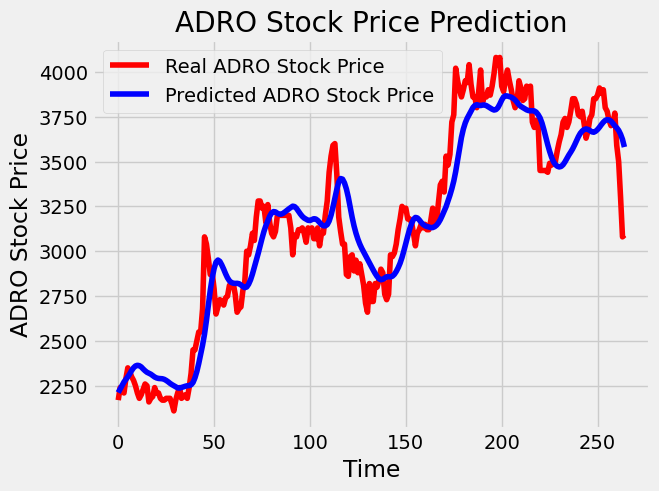

In [ ]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [ ]:
# Evaluating GRU with RMSE and MAPE
rmse = np.sqrt(np.mean((test_set - GRU_predicted_stock_price) ** 2))
print(f"RMSE: {rmse:.4f}")

mape = mean_absolute_percentage_error(test_set, GRU_predicted_stock_price)
print(f"MAPE: {mape*100:.2f}%")

r2 = r2_score(test_set, GRU_predicted_stock_price)
print(f"R²: {r2:.4f}")

RMSE: 174.4986
MAPE: 4.36%
R²: 0.9022


Qualitatively, the LSTM with GRU model also shows a pattern that closely resembles the actual data, although not as accurately as the standalone LSTM model.

Quantitatively, the following values were obtained for model evaluation:
- RMSE: 174.4986
- MAPE: 4.36%
- R2: 0.9022

## RESULT

Based on the prediction results, the following values were obtained for model evaluation:

LSTM Model
- RMSE: 135.3097
- MAPE: 3.42%
- R2: 0.9412

LSTM with GRU Model
- RMSE: 174.4986
- MAPE: 4.36%
- R2: 0.9022

From the results, it is evident that the LSTM model without GRU outperforms the LSTM model with GRU. The relatively large RMSE value is due to the large scale of the values in the stock data within the dataset. Therefore, even though the RMSE value appears high, the error percentage (MAPE) remains low, and the R2 value is close to 1. As a result, the model's accuracy can be considered acceptable.